# Morphological Filters in Julia

In [103]:
using Images
using Interpolations
function resize(img)
    imresize(img, (300, 300), method=Interpolations.Constant())
end

resize (generic function with 1 method)

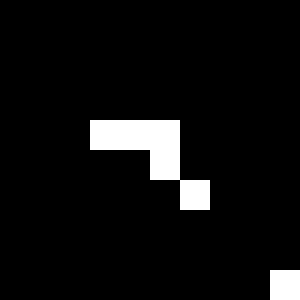

In [104]:
img1 = Gray.(zeros(10, 10))
img1[5, 5] = 1.0
img1[5, 4] = 1.0
img1[5, 6] = 1.0
img1[6, 6] = 1.0
img1[7, 7] = 1.0
img1[10, 10] = 1.0
resize(img1)

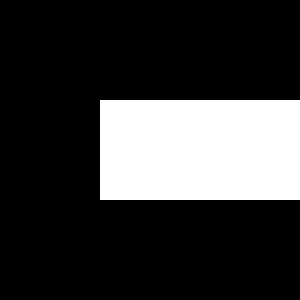

In [105]:
kernel1 = Gray.([0.0 0.0 0.0; 0.0 1.0 1.0; 0.0 0.0 0.0])
resize(kernel1)


In [106]:

# Dilution Function
function dilution_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    y_kernel_dim, x_kernel_dim = size(kernel) # eg. 3,3
    focus_y, focus_x = ceil(Int, y_kernel_dim / 2), ceil(Int, x_kernel_dim / 2) # eg. 2,2
    height, width = size(image) # eg. 10,10
    result_image = Gray.(zeros(height + y_kernel_dim - 1, width + x_kernel_dim - 1)) #eg. 12,12
    for j in 1:y_kernel_dim
        for i in 1:x_kernel_dim
            if kernel[j, i] == 1.0
                # the kernel pixel is active
                offset_y, offset_x = j - focus_y, i - focus_x
                for y in 1:height
                    for x in 1:width
                        if image[y, x] == 1.0
                            result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1] = 1.0
                        end
                    end
                end
            end


        end
    end

    return result_image[2:end-1, 2:end-1]
end

dilution_binary (generic function with 2 methods)

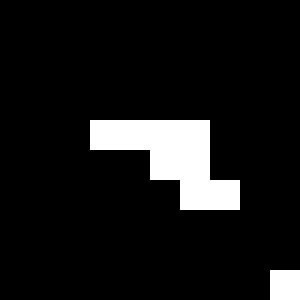

In [107]:
resize(dilution_binary(img1, kernel1))

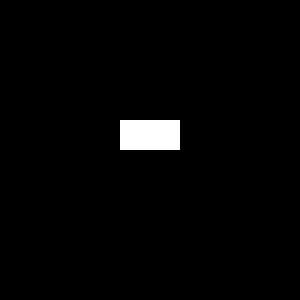

In [108]:
invert(image::Matrix{Gray{Float64}}) = image .* -1 .+ 1

function erosion_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    invert(dilution_binary(invert(image), kernel))
end

resize(erosion_binary(img1, kernel1))


In [109]:

# Dilution Function for continous images.
# Here in the kernel values of 99 are ignored
function dilution_continous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    y_kernel_dim, x_kernel_dim = size(kernel) # eg. 3,3
    focus_y, focus_x = ceil(Int, y_kernel_dim / 2), ceil(Int, x_kernel_dim / 2) # eg. 2,2
    height, width = size(image) # eg. 10,10
    result_image = Gray.(zeros(height + y_kernel_dim - 1, width + x_kernel_dim - 1)) #eg. 12,12
    for j in 1:y_kernel_dim
        for i in 1:x_kernel_dim
            if kernel[j, i] != 99.0
                # the kernel pixel is active
                offset_y, offset_x = j - focus_y, i - focus_x
                for y in 1:height
                    for x in 1:width
                        prev_cell = result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1]
                        maybe_next_cell = kernel[j, i] * image[y, x]
                        if maybe_next_cell > prev_cell
                            result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1] = maybe_next_cell
                        end
                    end
                end
            end


        end
    end
    return result_image[2:end-1, 2:end-1]
end


function erosion_continous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    invert(dilution_continous(invert(image), kernel))
end

erosion_continous (generic function with 1 method)

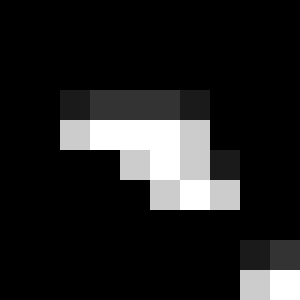

In [110]:
kernel_c = Gray.([
    0.1 0.2 0.1
    0.8 1.0 0.8
    99.0 99.0 99.0])

resize(dilution_continous(img1, kernel_c))

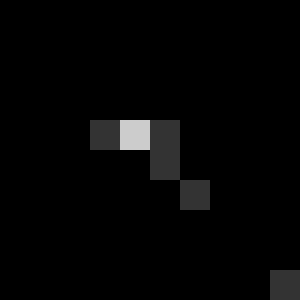

In [111]:
resize(erosion_continous(img1, kernel_c))

# trying some nicer images and kernels